# Introduction
The aim of this script is to compare the results of the different models. 
# Comparison
## Imports

In [1]:
import os, glob, itertools, json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report

# pd.set_option('display.max_columns', None)
# pd.set_option('max_colwidth', None)


## Load Data

In [2]:
# Load test validation data
path = Path('./raw_data/validation_data/')
# Create dataframe
df = pd.DataFrame()
# Encoding labels
label_encoding = {'0':'cat', '1':'dog'}
# Add columns
df = (df
    .assign(path_to_file = ['./' + str(path) + '/' + f for f in os.listdir(path)])
    .assign(category_name = lambda x: x.path_to_file.str.split('/').str[-1].str.split('.').str[0])
    .assign(category = lambda x: 
        np.where(x.path_to_file.str.split('/').str[-1].str.split('.').str[0] == 'cat', '0', '1')
    )
    .assign(filename = lambda x: x.path_to_file.str.split('/').str[-1])
)

df.sample(5)

,path_to_file,category_name,category,filename
168,./raw_data/validation_data/cat.7303.jpg,cat,0,cat.7303.jpg
50,./raw_data/validation_data/dog.8414.jpg,dog,1,dog.8414.jpg
309,./raw_data/validation_data/cat.8255.jpg,cat,0,cat.8255.jpg
885,./raw_data/validation_data/dog.5116.jpg,dog,1,dog.5116.jpg
320,./raw_data/validation_data/dog.8529.jpg,dog,1,dog.8529.jpg


In [3]:
print(
    df.category_name.value_counts(),
)

cat    496
dog    489
Name: category_name, dtype: int64


The validation data consists of `496` (cats) and `489` (dogs) images. This images have never been seen during training and are therefore used in order to compare the results of the different models.

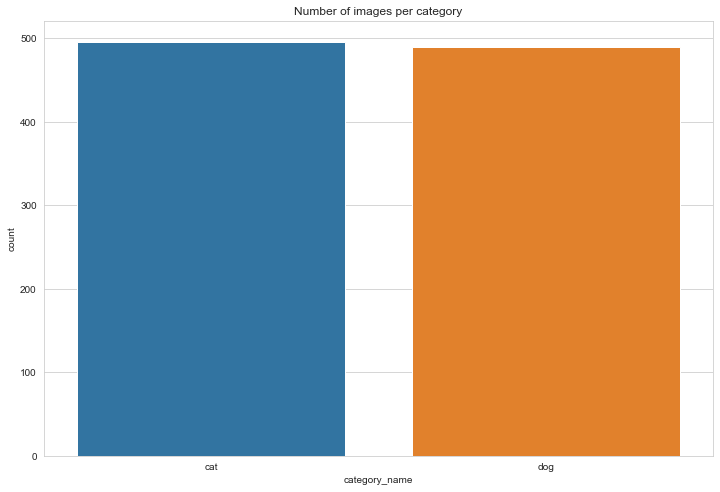

In [4]:
# Create bar chart of the number of images per category
sns.set_style('whitegrid')
sns.countplot(x='category_name',data = df).set_title('Number of images per category')
plt.show()

## Load Models & Evaluation

In [5]:
# Load models
def load_model(model_name):
    return tf.keras.models.load_model(model_name)
    #return model_name

## Get model names
path = Path('./models/')
models = {model.name:load_model(model) for model in list(path.glob('*.h5'))}

# Setup data generator
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width,Image_Height)
Image_Channels = 3
batch_size = 15

# Create generator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = df, 
    x_col='path_to_file',
    y_col='category',
    target_size = Image_Size,
    class_mode = 'binary',
    batch_size = batch_size,
)

# Generate list of labels
labels_test = validation_generator.labels

## Create a dataframe of the ground truth and predictions
predictions = pd.DataFrame()
predictions = (
    predictions
        .assign(model_name = [model for model in models.keys()]) # Create a new column for the model name
        .assign(y_true = [labels_test for i in range(len(models))]) # Create a new column for the ground truth, always the same value
        .assign(y_pred = lambda column: 
            column.model_name.apply(lambda model: np.around(models[model].predict(validation_generator)).flatten())
        ) # Create a new column for the predictions
    )

predictions.head()

2022-02-27 03:06:29.659275: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 985 validated image filenames belonging to 2 classes.


,model_name,y_true,y_pred
0,base_line_catsVSdogs_20epoch.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
1,3-conv-64-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
2,2-conv-256-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
3,3-conv-128-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."
4,4-conv-64-nodes-20220219112148.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [16]:
predictions

,model_name,y_true,y_pred
0,base_line_catsVSdogs_20epoch.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
1,3-conv-64-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
2,2-conv-256-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
3,3-conv-128-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."
4,4-conv-64-nodes-20220219112148.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
5,2_conv_128_nodes-Batchnorm-Dropout-20220226172...,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
6,4-conv-128-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7,transfer_learning_trainables_true.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[-6.0, -6.0, 4.0, -3.0, 4.0, -8.0, 5.0, -5.0, ..."
8,2-conv-128-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
9,3-conv-256-nodes-20220226172309.h5,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [12]:
# Check the length of the predictions vs. the ground truth
for index, row in predictions.iterrows():
    print(row.model_name)
    if len(labels_test) == len(row.y_pred): 
        print('OK!')
        print('**************************')
    else:
        print('ERROR!!!!!!!')
        print('Number of y_true and y_pred do not match')
        print('Length of y_true: ',len(labels_test))
        print('Length of y_pred: ',len(row.y_pred))
        print('**************************')

base_line_catsVSdogs_20epoch.h5
OK!
**************************
3-conv-64-nodes-20220226172309.h5
OK!
**************************
2-conv-256-nodes-20220226172309.h5
OK!
**************************
3-conv-128-nodes-20220226172309.h5
OK!
**************************
4-conv-64-nodes-20220219112148.h5
OK!
**************************
2_conv_128_nodes-Batchnorm-Dropout-20220226172309.h5
OK!
**************************
4-conv-128-nodes-20220226172309.h5
OK!
**************************
transfer_learning_trainables_true.h5
OK!
**************************
2-conv-128-nodes-20220226172309.h5
OK!
**************************
3-conv-256-nodes-20220226172309.h5
OK!
**************************
4-conv-64-nodes-20220226172309.h5
OK!
**************************
2-conv-64-nodes-20220226172309.h5
OK!
**************************
4-conv-128-nodes-20220219112148.h5
OK!
**************************
4-conv-256-nodes-20220226172309.h5
OK!
**************************


In [7]:
# # Create Classification Report
# df_metrics = pd.DataFrame()

# for model in predictions.model_name:
#     print(
#         'Groundtruth: ', predictions[predictions.model_name == model].y_true.shape,
#         'Prediction: ', predictions[predictions.model_name == model].y_pred.shape,
#     )

In [8]:
# ########### Alternative method ###########
#
# # Alternative approach to create predictions
# for n, model in enumerate(models):
#     print('*'*50)
#     print(model)
#     exec(f'model_{n} = models[model]')
#     print(f'model_{n} loaded')
#     exec(f'prediction_{n} = np.around(model_{n}.predict(validation_generator)).flatten()')
#     print(f'model_{n} predicted')  

# for prediction in [prediction_0, prediction_1, prediction_2]:
#     matrix_confusion = confusion_matrix(labels_test, prediction)
#     sns.heatmap(matrix_confusion, annot=True, fmt='d', cmap='Blues', cbar=False).set_title(f'Confusion Matrix')
#     plt.show()

In [9]:
# # Create y_true and y_pred vectors
# y_true = list(itertools.chain(*predictions[predictions.model_name != 'resnet_model-2.h5'].y_true))
# y_pred = list(itertools.chain(*predictions[predictions.model_name != 'resnet_model-2.h5'].y_pred))

# # Print out for check
# print(
#     f'The length of y_true is: {len(y_true)}\n',
#     f'The length of y_pred is: {len(y_pred)}',
# )

# # Classification Report
# report = classification_report(
#     y_true = y_true, 
#     y_pred = y_pred,
#     output_dict = True,
# )

# # Merge 
# results = (pd.DataFrame(data = report, columns = list(report.keys()))
#     .T
#     .reset_index()
#     .rename(columns = {'index':'categories','f1-score':'f1_score'})
#     .drop(columns=['support'])
#     )

# results

The length of y_true is: 13790
 The length of y_pred is: 13790


/Users/Bernardo/opt/anaconda3/envs/vision/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Bernardo/opt/anaconda3/envs/vision/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Bernardo/opt/anaconda3/envs/vision/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

,categories,precision,recall,f1_score
0,-10.0,0.000000,0.000000,0.000000
1,-9.0,0.000000,0.000000,0.000000
2,-8.0,0.000000,0.000000,0.000000
3,-7.0,0.000000,0.000000,0.000000
4,-6.0,0.000000,0.000000,0.000000
5,-5.0,0.000000,0.000000,0.000000
6,-4.0,0.000000,0.000000,0.000000
7,-3.0,0.000000,0.000000,0.000000
8,-2.0,0.000000,0.000000,0.000000
9,-1.0,0.000000,0.000000,0.000000


In [15]:
results = {}

for model in predictions.model_name:
    if model == 'resnet_model-2.h5':
        continue
    else:
        # Create y_true and y_pred vectors
        y_true = list(itertools.chain(*predictions[predictions.model_name == model].y_true))
        y_pred = list(itertools.chain(*predictions[predictions.model_name == model].y_pred))

        # # Print out for check
        # print(
        #     f'Model is {model}\n',
        #     f'The length of y_true is: {len(y_true)}\n',
        #     f'The length of y_pred is: {len(y_pred)}',
        # )

        # Classification Report
        report = classification_report(
            y_true = y_true, 
            y_pred = y_pred,
            output_dict = True,
            zero_division = True,
        )

        # 
        if not isinstance(results, pd.DataFrame):
            results = (pd.DataFrame(data = report, columns = list(report.keys()))
                .T
                .assign(model = model)
                .reset_index()
                .rename(columns = {'index':'categories','f1-score':'f1_score'})
                .drop(columns=['support'])
                )
        else:
            temp = (pd.DataFrame(data = report, columns = list(report.keys()))
                .T
                .assign(model = model)
                .reset_index()
                .rename(columns = {'index':'categories','f1-score':'f1_score'})
                .drop(columns=['support'])
                )
            results = pd.concat([results, temp])

#results = results[(results.categories == '0') & (results.categories == '1')]
results

import os  
os.makedirs('overview', exist_ok=True)  
results.to_csv('overview/results.csv')  

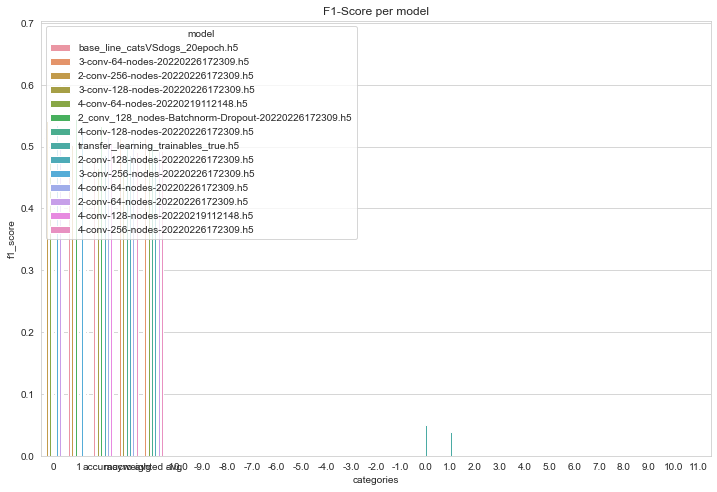

In [14]:
# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = results.categories,
    y = results.f1_score,
    data = results,
    hue="model"
    )
plt.title('F1-Score per model')
plt.show()

## Conclusions
# Learnings
